In [3]:
from networkx.algorithms.bipartite.basic import color
%matplotlib inline
import torch
import  numpy as np
from mpl_toolkits import mplot3d
import d2l

In [4]:
def f(X):
    return X * torch.cos(np.pi * X)

def g(X):
    """
    torch.cos(5 * np.pi * X)是一个高频的余弦函数，添加这一项可以惩罚模型中可能出现的高频变化
    在实际应用中，高频变化往往对应着训练模型对训练数据的过拟合，通过添加这一正则化项，可以让模型
    更加平滑，提高其泛化能力。
    系数 0.2 则控制了正则化项的权重。若这个数值过大，模型会过于平滑，可能导致欠拟合。
    """
    return f(X) + 0.2 * torch.cos(5 * np.pi * X)

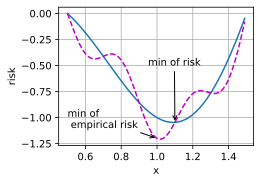

In [12]:
def annotate(text, xy, xytext):
    d2l.plt.gca().annotate(text, xy=xy, xytext=xytext,
                           arrowprops=dict(arrowstyle="->"))

x = torch.arange(0.5, 1.5, 0.01)
d2l.set_figsize((4.5, 2.5))
d2l.plot(x, [f(x), g(x)], 'x', 'risk')
annotate("min of\n empirical risk", (1.0, -1.2), (0.5, -1.1))
annotate("min of risk", (1.1, -1.05), (0.95, -0.5))

In [13]:
%matplotlib inline
import numpy as np
import torch
import d2l

In [14]:
def f(x): # 目标函数
    return x ** 2

def f_grad(x): # 目标函数的梯度
    return x * 2

epoch 10, x:7.295479


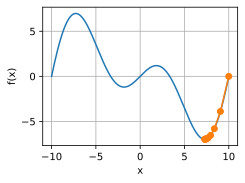

In [31]:
# 使用 x=0 作为初值，并假设 eta=0.2。使用梯度下降法迭代 x 共十次
def gd(eta, f_grad):
    x = 10.0
    result = [x]
    for i in range(10):
        x -= eta * f_grad(x)
        result.append(float(x))
    print(f"epoch 10, x:{x:f}")
    return result

result = gd(0.2, f_grad)

# 绘制 x 的梯度下降图
def show_trace(result, f):
    n = max(abs(min(result)), abs(max(result)))
    f_line = torch.arange(-n, n, 0.01)
    d2l.set_figsize()
    d2l.plot([f_line, result], [[f(x) for x in f_line], [f(x) for x in result]],
             'x', 'f(x)', fmts=['-', '-o'])

show_trace(result, f)

epoch 10, x:8.284779


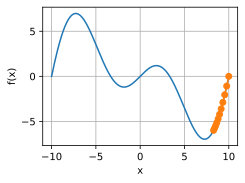

In [29]:
# 学习率较小的情况
show_trace(gd(0.05, f_grad), f)

epoch 10, x:61.917364


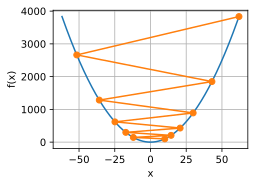

In [17]:
# 学习率较大反而可能导致发散或抖动
show_trace(gd(1.1, f_grad), f)

In [19]:
def train_2d(trainer, steps=20, f_grad=None):
    """
    用定制的训练机优化2D目标函数
    """
    x1, x2, s1, s2 = -5, -2, 0, 0
    results = [(x1, x2)]
    for i in range(steps):
        if f_grad:
            x1, x2, s1, s2 = trainer(x1, x2, s1, s2, f_grad)
        else:
            x1, x2, s1, s2 = trainer(x1, x2, s1, s2)
        results.append((x1, x2))
    print(f"epoch {i+1}, x1: {float(x1):f}, x2: {float(x2):f}")
    return results

def show_trace_2d(f, results):
    """
    显示优化过程中2D变量的轨迹
    """
    d2l.set_figsize()
    d2l.plt.plot(*zip(*results), '-o', color="#ff7f0e")
    x1, x2 = torch.meshgrid(
        torch.arange(-5.5, 1.0, 0.1),
        torch.arange(-3.0, 1.0, 0.1),
        indexing='ij'
    )
    d2l.plt.contour(x1, x2, f(x1, x2), colors="#1f77b4")
    d2l.plt.xlabel('x1')
    d2l.plt.ylabel('x2')

epoch 20, x1: -0.057646, x2: -0.000073


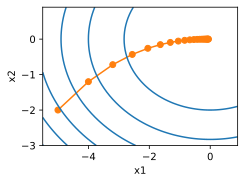

In [21]:
def f_2d(x1, x2): #目标函数
    return x1 ** 2 + 2 * x2 ** 2

def f_2d_grad(x1, x2): # 目标函数的梯度
    return  (2 * x1, 4 * x2)

def gd_2d(x1, x2, s1, s2, f_grad): # 更新函数
    g1, g2 = f_grad(x1, x2)
    return (x1 - eta * g1, x2 - eta * g2, 0, 0)

eta = 0.1
show_trace_2d(f_2d, train_2d(gd_2d, f_grad=f_2d_grad))

epoch 10, x: tensor(0.)


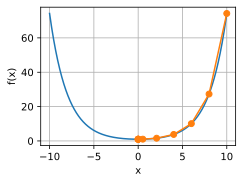

In [22]:
# 使用牛顿法进行梯度迭代
c = torch.tensor(0.5)

def f(x): # O目标函数
    return torch.cosh(c * x)

def f_grad(x): # 目标函数的梯度
    return c * torch.sinh(c * x)

def f_hess(x): # 目标函数的Hessian
    return c**2 * torch.cosh(c * x)

def newton(eta=1):
    x = 10.0
    results = [x]
    for i in range(10):
        x -= eta * f_grad(x) / f_hess(x)
        results.append(float(x))
    print('epoch 10, x:', x)
    return results

show_trace(newton(), f)

epoch 10, x: tensor(26.8341)


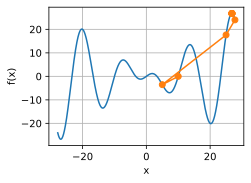

In [23]:
# 在牛顿法中，我们最终将除以 Hessian。这意味着如果二阶导数是负的，f值可能趋于增加
c = torch.tensor(0.15 * np.pi)

def f(x): # 目标函数
    return x * torch.cos(c * x)

def f_grad(x): # 目标函数的梯度
    return torch.cos(c * x) - c * x * torch.sin(c * x)

def f_hess(x): # 目标函数的Hessian
    return - 2 * c * torch.sin(c * x) - x * c**2 * torch.cos(c * x)

show_trace(newton(), f)

epoch 10, x: tensor(20.2219)


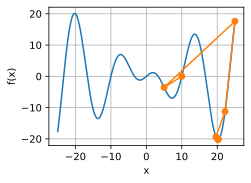

In [24]:
# 一种修正办法是取 Hessian 的绝对值
# 在牛顿法中，我们最终将除以 Hessian。这意味着如果二阶导数是负的，f值可能趋于增加
c = torch.tensor(0.15 * np.pi)

def f(x): # 目标函数
    return x * torch.cos(c * x)

def f_grad(x): # 目标函数的梯度
    return torch.cos(c * x) - c * x * torch.sin(c * x)

def f_hess(x): # 目标函数的Hessian
    return - 2 * c * torch.sin(c * x) - x * c**2 * torch.cos(c * x)

def newton(eta=1):
    x = 10.0
    results = [x]
    for i in range(10):
        x -= eta * f_grad(x) / abs(f_hess(x))
        results.append(float(x))
    print('epoch 10, x:', x)
    return results

show_trace(newton(), f)

epoch 10, x: tensor(7.2699)


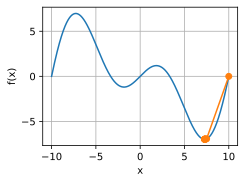

In [32]:
show_trace(newton(0.5), f)

epoch 50, x1: 0.318681, x2: 0.187765


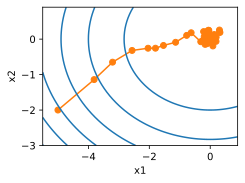

In [38]:
# 我们比较梯度下降(GD)和随机梯度下降(SGD)，方法是向梯度添加均值为0，方差为1的随机噪声
def f(x1, x2): # 目标函数
    return x1 ** 2 + 2 * x2 ** 2

def f_grad(x1, x2): # 目标函数的梯度
    return x1 * 2, 4 * x2

def sgd(x1, x2, s1, s2, f_grad):
    g1, g2 = f_grad(x1, x2)
    # 模拟有噪声的梯度
    g1 += torch.normal(0.0, 1, (1,)).item()
    g2 += torch.normal(0.0, 1, (1,)).item()
    eta_t = eta * lr() # lr() 是学习率函数
    return (x1 - eta_t * g1, x2 - eta_t * g2, 0, 0)

def constant_lr():
    return 1

eta = 0.1
lr = constant_lr
d2l.show_trace_2d(f, d2l.train_2d(sgd, steps=50, f_grad=f_grad))

epoch 1000, x1: -0.785981, x2: -0.039780


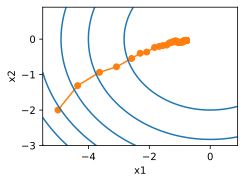

In [40]:
import math

def exponential_lr():
    # 在函数外部定义，而在函数内部更新的全局变量
    global t
    t += 1
    return math.exp(-0.1 * t)

t = 1
lr = exponential_lr
d2l.show_trace_2d(f, d2l.train_2d(sgd, steps=1000, f_grad=f_grad))

epoch 50, x1: 0.223332, x2: 0.006072


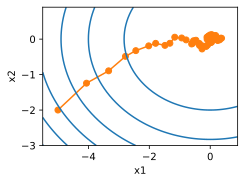

In [41]:
def polynomial_lr():
    # 在函数外部定义，而在内部更新的全局变量
    global t
    t += 1
    return (1 + 0.1 * t) ** (-0.5)

t = 1
lr = polynomial_lr
d2l.show_trace_2d(f, d2l.train_2d(sgd, steps=50, f_grad=f_grad))